# Working with Pandas using Stock Prices

<p>Let's start here.  In Python, as in most programming languages, we have the ability to get very granualar in how we interact with the computer, but we can also stand on the shoulders of giants and reuse their work.  This is what we will opt to do as often as possible, other people have figured out the gory details of how to interpret the format of an Excel file so we don't have to - I'd rather depend on their work and focus on the real value add for our projects - that is spending time doing something with the data!</p>
<br/>
So the first thing we are going to do is ask Python to "load" up the code that knows how to read Exxcel files.  The code is stored in a "module" called pandas (keep in mind that case matters, so Pandas is not the same as pandas).  For simplicity we are going to ask Python to make the utilities in this module available to us whenever we specify the shortcut 'pd'.  (The pd shortcut is common for Pandas).  On to the first set of code.

In [157]:
# Because we are using an on-line environment, we need an extra library.  If running locally, we can do this once and then never again
!pip install  plotnine

You should consider upgrading via the 'pip install --upgrade pip' command.


In [181]:
# Notice the '#' symbol?  This symbol tells Python that we don't want it to try to 'run' the code on this line of text
# This syntax is called a comment, and we can use it to clarify difficult code, or provide a hint as to what the next line (or several lines)
#  of code are meant to do

# Bring the Python module that can read Excel files into our scope so that we can use it, along with a few other helpful libraries
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib
import math
from scipy.stats import norm
from dateutil.parser import *
from datetime import *
from dateutil.rrule import *
import holidays
pd.set_option('precision', 4)


In [ ]:
# The two key things that Pandas provides us is a Series datatype and a Dataframe.  A series is like a list of values that have an index like a number or
# a date value or a string.  A dataframe is a collection of Series all which share the same index.  So you can think of a dataframe type like a spreadsheet,
# just like when you open a spreadsheet and you see the row numbers on the left side and the column headers across the top, a pandas dataframe is similar
df = pd.read_csv('data/spy_012920.csv',index_col='Date', infer_datetime_format=True, parse_dates=True)
# The head function, lets use see the first few lines of the file we have loaded from the CSV file
print(df.shape)
df.head()

# Plotting
Okay, we'll we have some data, now let's explore that data a bit.  It would be helpful to create a chart - yes?

In [ ]:
df['Adj Close'].plot();

# Column Calculations

Looking at a chart is great, but what if what we want isn't in the data, and we have to calculate it?  For instance, what if we were interested in the percent change daily?  One way to calculate this is

$\frac{(Close - Open)}{Open}*100\% = \%daily change$

In [ ]:
df['daily change pct'] = ((df['Close']-df['Open'])/df['Open'])*100
df.head()

## Determining the number of up days versus down

Just looking at the data, it seems that it would be interesting to know how many days the stock went up vs going down, so we can apply an *aggregate* function to a column of data as well.  Let's count ups and downs.


In [ ]:
# This first statement creates a boolean series with True in every row where the condition is satisfied and False otherwise.
updays_filter = df['daily change pct'] > 0
print(updays_filter.head())
# Then we can use this filter (also called a boolean mask) to select just the rows we are interested in and apply our aggregate function these rows
print(df.loc[updays_filter].count())

# This is helpful, but I don't need to see the same count for all of the columns, maybe just one?
updays = df.loc[updays_filter, 'daily change pct'].count()
print(f'\nJust the up days please: {updays}')

# That's better.  No about the down days.  We can certainly just reverse the equation like so
downdays_filter = df['daily change pct'] < 0

# But there is even a better way.  The tilde symbol (~) says to apply the boolean opposite to the series, so that True's become False
downdays_filter = ~updays_filter
downdays = df.loc[downdays_filter,'daily change pct'].count()


print(f'\n\nUpdays {updays}.  Downdays: {downdays}')

## Rolling Windows

Of course, we have the ability to apply all manner of aggregate functions (that is, functions that take a list of numbers and calculate a single result) such as mean, median, count, sum, std, var etc.  But often times we want not to work with the entire dataset, but just a portion of the window.  For instance, we want to know the 30-day moving average of the stock close price.  Pandas allows us this with the "rolling" function.

In [ ]:
df['30DMA'] = df['Close'].rolling(30).mean()


# Let's plot it along with the close price but on two separate figures
df[['30DMA','Close']].plot(subplots=True, figsize=(6,6));

In [ ]:
# Let's add in the 200 day moving average as well and then plot them together
df['200DMA'] = df['Close'].rolling(200).mean()

df[['30DMA','200DMA']].plot(figsize=(6,6));

In [ ]:
# In order to get the last say 100 days, we need to get an offset of days

TODAY = pd.datetime.today()
offset = pd.Timedelta(days=100)
last_100 = df[TODAY-offset:]
last_100

In [ ]:
# Or if we want a specific timeframe like this year
df.loc['2020']

In [ ]:
# Or maybe we want everything from Dec 2019 til now
df['12-2019':]

# Black-Sholes Calculations

The Black-Sholes pricing model can be calculated using the _current price_, _strike price_, _volatility_, _risk free rate_, and the _expiration_.  Two approaches are outlined here - first given a specific date, we can parse and figure out the number of days.  The second takes the number of days directly.

In [182]:
%run Pricing-Models.ipynb

Call Price: 12.61
Put Price: 15.19
Call Price: 0.40
Put Price: 6.84
Call Price: 12.62
Put Price: 15.21


In [172]:
# Notice when we call this function, that both the Call Price and the Put Price are returned
currentPrice = 333.45
volatility = 0.125
strikePrice = 340
riskFreeRate = 0.017
expiration = '12/31/2020'

callPrice, putPrice = BlackSholes(currentPrice, strikePrice, volatility, riskFreeRate, expiration)
print(f'Call Price: {callPrice:0.2f}')
print(f'Put Price: {putPrice:0.2f}')

Call Price: 12.61
Put Price: 15.19


In [173]:
# If we wanted to try a number of volatilities we could just as easily put these in an array and then call them 
options_12_20 = pd.DataFrame({'vol':np.arange(0.12,0.20,0.01)})
options_12_20['bs'] = options_12_20['vol'].apply(lambda x: BlackSholes(currentPrice, strikePrice, x, riskFreeRate,expiration))

# Just a bit of magic to get the values returned from a tuple into two columns
options_12_20[['call', 'put']] = pd.DataFrame(options_12_20['bs'].tolist(), index=options_12_20.index)
options_12_20.drop(columns='bs',inplace=True)
options_12_20['actual call'] = 14.69
options_12_20['actual put'] = 21.80

options_12_20

,vol,call,put,actual call,actual put
0,0.12,12.0583,14.6411,14.69,21.8
1,0.13,13.1634,15.7461,14.69,21.8
2,0.14,14.2686,16.8514,14.69,21.8
3,0.15,15.3739,17.9567,14.69,21.8
4,0.16,16.4793,19.0620,14.69,21.8
5,0.17,17.5845,20.1673,14.69,21.8
6,0.18,18.6896,21.2724,14.69,21.8
7,0.19,19.7946,22.3773,14.69,21.8
8,0.20,20.8993,23.4820,14.69,21.8


ModuleNotFoundError: No module named 'pandas.plotting._timeseries'

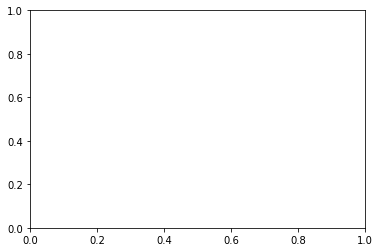

In [174]:
# and then we already know how to plot
options_12_20.plot(x='vol');

# Okay, time to get a bit more clever

We can do something called multi-level indexing.  In other words, we might want to get the put and call prices for a range of dates and volatilities rather than just just a single day.  We can also calculate the prices a number of different strike prices, then we'll have a whole slew of data to pick from.

So we start by creating a list of dates when the options expire.  For SPY this means every Mon-Wed-Fri, for other stocks it's usually every Friday for the next 6 weeks then the third Friday of the month.  For our purposes we are just going to look at options that expire on monthly cycles for the next 12 months.  Keep in mind that we have to take into account holidays, so if the Friday expiration falls on a holiday, then it expires on Thursday.

For this handy little bit of help, we are going to use [dateutil](https://dateutil.readthedocs.io/en/stable/) and also we want to handle holidays so we'll depend on [holidays](https://pypi.org/project/holidays/).  We've got the handy library dateutil to allows us to do timemath relatively easily (that is calculate the 3rd Friday of the month for the next 12 months).  Then we'll make sure that these days don't fall on a holiday, in which case, we need to expire on Thursday instead.

In [175]:
# Start with figuring out the options dates (this says, starting today, give me every 3rd Friday of the month for a year)
expiration_dates = [dt.date() for dt in rrule(MONTHLY, count=12, byweekday=FR(3))]
us_holidays = holidays.UnitedStates()
expiration_dates = [x-timedelta(-1) if x else x in us_holidays for x in expiration_dates]

# Now, give me a range of volatilities the first parameter is start, second is end, third is step
# due to a "bug" in numpy's range function, I have to first move by ints then divide by 100
volatilities = np.arange(12,20) * 0.01

# And if we like we can also add strike prices, let's start with the stock's current price and give ourselves 10 options
# in either direction, in 2.50 increments rounded to the nearest $2.50 above or below the price...  
# So for the case where a stock is $86, we'll start going down from $85, $82.50.... and up from $85
strike_midpoint=2.5 * round(currentPrice/2.5)
strike_range = np.arange(strike_midpoint-25,strike_midpoint+25,2.5)

indexes = pd.MultiIndex.from_product([expiration_dates,strike_range, volatilities],names=['Expiration', 'Strike','Volatility'])
df_options = pd.DataFrame(index=indexes)
df_options.reset_index(inplace=True)
df_options.head()


,Expiration,Strike,Volatility
0,2020-05-16,307.5,0.12
1,2020-05-16,307.5,0.13
2,2020-05-16,307.5,0.14
3,2020-05-16,307.5,0.15
4,2020-05-16,307.5,0.16


## Calculating values

Now we need to go through the effort to calculate BS prices for each of these three variables strike price, expiration, and volatility.  We want to do what we did before with the getting the call prices and put prices so that we can determine which ones make the most sense to us.


In [180]:
# This code says..  for every row in the data, apply the BlackSholes function with the Strike, Volatility, and Expiration
# the results should be put into two columns called Call and Put upon the return
df_options[['Call','Put']] = df_options.apply(lambda x: BlackSholes(currentPrice, 
                                                          x['Strike'], 
                                                          x['Volatility'], 
                                                          riskFreeRate, 
                                                          x['Expiration']),
                                              axis=1, result_type='expand')

# And just so that we are back where we started, let's recreate our multi-index
df_options['Expiration'] = pd.to_datetime(df_options['Expiration'])
df_options.set_index(['Expiration', 'Strike', 'Volatility'], inplace=True)
df_options.head()

TypeError: ("unsupported operand type(s) for -: 'Timestamp' and 'datetime.date'", 'occurred at index 0')

In [ ]:
# Now we can do business on our dataframe, let's say we want to look at all the prices for the May expiration
df_options.loc[('05-2020')]

In [ ]:
# Or what if we only want the values in May 2020 that have a strike of 352.5
df_options.loc[('5-2020',352.5),]

In [ ]:
# We can also look at all the options with a volatility that we believe in
df_options.xs(0.16,axis=0,level=2, drop_level=False)

In [ ]:
# A few other ways to 'slice' the data include specifying two of the values, like Strike and Volatility
df_options.loc[(slice(None),350.,0.15),]

# Let's do this in an interactive way
Now that we have a few different methods to price options let's see if we can compare the results.



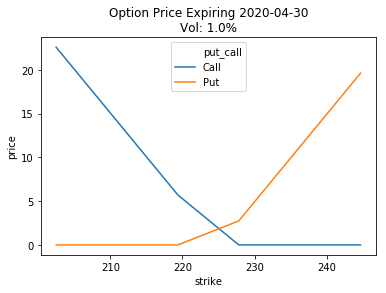

In [160]:
# %matplotlib notebook
import ipywidgets as widgets
from ipywidgets import Button, FloatText, DatePicker, HBox, VBox, FloatRangeSlider
from IPython.display import display
import numpy as np
import pdb; 
import datetime as dt
import seaborn as sns

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline


stock_current_value_default = 225
expiration_default = dt.date(2020,4,30)

txt_current = FloatText(description='Current Price', width='20%', value=stock_current_value_default)
txt_riskRate = FloatText(description='Risk Free Rate',value=0.01)
txt_expiration = DatePicker(description='Expiration', value=expiration_default)
in_vol_range = widgets.FloatSlider(description='Volatility',min=1,max=100,step=1, value=1)
btn_display = widgets.Button(description='Update Chart')
strike_range = FloatRangeSlider(description='Strike Price Range', 
                                value=[stock_current_value_default*.90, stock_current_value_default*1.10],
                                min=stock_current_value_default*.75, max=stock_current_value_default*1.5)

output = widgets.Output()
df_options = pd.DataFrame()

def on_graph_update(b):

    # Let's start with the stock's current price and give ourselves 10 options
    # in either direction, in 2.50 increments rounded to the nearest $2.50 above or below the price...  
    # So for the case where a stock is $86, we'll start going down from $85, $82.50.... and up from $85
    strike_step = (strike_range.max - strike_range.min) / 20
    strike_range_list = np.arange(strike_range.lower,strike_range.upper,strike_step)

    df_options = pd.DataFrame(strike_range_list,columns=['strike'])
    df_options[['Call','Put']] = df_options.apply(lambda x: BlackSholes(txt_current.value, 
                                                      x.strike, 
                                                      in_vol_range.value/100, 
                                                      riskFreeRate, 
                                                      txt_expiration.value),
                                                  axis=1, result_type='expand')
    df_options_long = pd.melt(df_options, ['strike'],var_name='put_call',value_name='price')

    # Use the expiration date and volatility as the Title of the graph
    sns.lineplot(x='strike',y='price', data=df_options_long, hue='put_call', ci=None,).set_title(f'Option Price Expiring {txt_expiration.value}\n'
                                                                                                 f'Vol: {in_vol_range.value}%');

#     ggplot(aes(x='strike', y='price'), data=df_options_long)+geom_line()
    
def on_price_update(change):
    new_current = change.new
    strike_range.min = 0 # This makes sure that the max is greater than the min when updated
    strike_range.max=new_current * 1.25
    strike_range.min=new_current * 0.75 
    strike_range.value = [new_current* .9, new_current* 1.1]

txt_current.observe(on_price_update, names='value')
btn_display.on_click(on_graph_update)

VBox([txt_current, txt_riskRate, txt_expiration,in_vol_range, strike_range, btn_display])

In [167]:
# Let's start with the stock's current price and give ourselves 10 options
# in either direction, in 2.50 increments rounded to the nearest $2.50 above or below the price...  
# So for the case where a stock is $86, we'll start going down from $85, $82.50.... and up from $85
strike_step = (strike_range.max - strike_range.min) / 20
strike_range_list = np.arange(strike_range.lower,strike_range.upper,strike_step)

df_options = pd.DataFrame(strike_range_list,columns=['strike'])
df_options[['Call','Put']] = df_options.apply(lambda x: BlackSholes(txt_current.value, 
                                                  x.strike, 
                                                  in_vol_range.value/100, 
                                                  riskFreeRate, 
                                                  txt_expiration.value),
                                              axis=1, result_type='expand')
df_options_long = pd.melt(df_options, ['strike'],var_name='put_call',value_name='price')
pd.set_option('precision',5)
df_options_long

,strike,put_call,price
0,202.5000,Call,2.25660e+01
1,210.9375,Call,1.41313e+01
2,219.3750,Call,5.69655e+00
3,227.8125,Call,2.55413e-02
4,236.2500,Call,2.82632e-13
5,244.6875,Call,1.04685e-34
6,202.5000,Put,6.45046e-54
7,210.9375,Put,5.83654e-22
8,219.3750,Put,3.92959e-05
9,227.8125,Put,2.76378e+00
